In [7]:
import os
import torch.autograd as autograd
import torch
import copy
from torch import nn
import torch.nn.functional as F
import cv2
import numpy as np
from tqdm import tqdm
import os
from AV.models.layers import *
from AV.Tools.ImageResize import creatMask, shift_rgb
from AV.lib.Utils import *
from PIL import Image
from skimage import morphology, measure
import scipy.ndimage.morphology as scipyMorphology
from skimage.morphology import skeletonize, erosion, square,dilation
from scipy.signal import convolve2d
from finetune.convnext import convnext_tiny
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:

def binaryPostProcessing3(BinaryImage, removeArea, fillArea):
    """
    Post process the binary image
    :param BinaryImage:
    :param removeArea:
    :param fillArea:
    :return: Img_BW
    """

    BinaryImage[BinaryImage>0]=1

    ####takes 0.9s, result is good
    Img_BW = BinaryImage.copy()
    BinaryImage_Label = measure.label(Img_BW)
    for i, region in enumerate(measure.regionprops(BinaryImage_Label)):
        if region.area < removeArea:
            Img_BW[BinaryImage_Label == i + 1] = 0
        else:
            pass

    # ####takes 0.01s, result is bad
    # temptime = time.time()
    # Img_BW = morphology.remove_small_objects(BinaryImage, removeArea)
    # print "binaryPostProcessing3, ITK_LabelImage time:", time.time() - temptime


    Img_BW = morphology.binary_closing(Img_BW, morphology.square(3))
    # Img_BW = remove_small_holes(Img_BW, fillArea)

    Img_BW_filled = scipyMorphology.binary_fill_holes(Img_BW)
    Img_BW_dif = np.uint8(Img_BW_filled) - np.uint8(Img_BW)
    Img_BW_difLabel = measure.label(Img_BW_dif)
    FilledImg = np.zeros(Img_BW.shape)
    for i, region in enumerate(measure.regionprops(Img_BW_difLabel)):
        if region.area < fillArea:
            FilledImg[Img_BW_difLabel == i + 1] = 1
        else:
            pass
        Img_BW[FilledImg > 0] = 1

    Img_BW = np.uint8(Img_BW)
    return Img_BW
def Skeleton(a_or_v, a_and_v):
    th = np.uint8(a_and_v)
    # Distance transform for maximum diameter
    vessels = th.copy()
    dist = cv2.distanceTransform(a_or_v, cv2.DIST_L2, 3)  
    thinned = np.uint8(skeletonize((vessels / 255))) * 255
    return thinned, dist
def cal_crosspoint(vessel):
    # Removing bifurcation points by using specially designed kernels
    # Can be optimized further! (not the best implementation)
    thinned1, dist = Skeleton(vessel, vessel)
    thh = thinned1.copy()
    thh = thh / 255
    kernel1 = np.array([[1, 1, 1], [1, 10, 1], [1, 1, 1]])

    th = convolve2d(thh, kernel1, mode="same")
    for u in range(th.shape[0]):
        for j in range(th.shape[1]):
            if th[u, j] >= 13.0:
                cv2.circle(vessel, (j, u), 2 * int(dist[u, j]), (0, 0, 0), -1)
    # thi = cv2.cvtColor(thi, cv2.COLOR_BGR2GRAY)
    return vessel

def AVclassifiation(PredAll1, PredAll2, VesselPredAll, DataSet=0, image_basename=''):
    """
    predAll1: predition results of artery
    predAll2: predition results of vein
    VesselPredAll: predition results of vessel
    DataSet: the length of dataset
    image_basename: the name of saved mask
    """

    ImgN = DataSet

    for ImgNumber in range(ImgN):

        height, width = PredAll1.shape[2:4]

        VesselProb = VesselPredAll[ImgNumber, 0, :, :]

        ArteryProb = PredAll1[ImgNumber, 0, :, :]
        VeinProb = PredAll2[ImgNumber, 0, :, :]

        VesselSeg = (VesselProb >= 0.1) & ((ArteryProb >0.2) | (VeinProb > 0.2))
        # VesselSeg = (VesselProb >= 0.5) & ((ArteryProb >= 0.5) | (VeinProb >= 0.5))
        crossSeg = (VesselProb >= 0.1) & ((ArteryProb >= 0.6) & (VeinProb >= 0.6))
        VesselSeg = binaryPostProcessing3(VesselSeg, removeArea=100, fillArea=20)

        vesselPixels = np.where(VesselSeg > 0)

        ArteryProb2 = np.zeros((height, width))
        VeinProb2 = np.zeros((height, width))
        crossProb2 = np.zeros((height, width))
        image_color = np.zeros((3, height, width), dtype=np.uint8)
        for i in range(len(vesselPixels[0])):
            row = vesselPixels[0][i]
            col = vesselPixels[1][i]
            probA = ArteryProb[row, col]
            probV = VeinProb[row, col]
            #probA,probV = softmax([probA,probV])
            ArteryProb2[row, col] = probA
            VeinProb2[row, col] = probV

        test_use_vessel = np.zeros((height, width), np.uint8)
        ArteryPred2 = ((ArteryProb2 >= 0.2) & (ArteryProb2 >= VeinProb2))
        VeinPred2 = ((VeinProb2 >= 0.2) & (VeinProb2 >= ArteryProb2))

        ArteryPred2 = binaryPostProcessing3(ArteryPred2, removeArea=100, fillArea=20)
        VeinPred2 = binaryPostProcessing3(VeinPred2, removeArea=100, fillArea=20)

        image_color[0, :, :] = ArteryPred2 * 255
        image_color[2, :, :] = VeinPred2 * 255
        image_color = image_color.transpose((1, 2, 0))

        #Image.fromarray(image_color).save(os.path.join(out_path, f'{image_basename[ImgNumber].split(".")[0]}_ori.png'))

        imgBin_vessel = ArteryPred2 + VeinPred2
        imgBin_vessel[imgBin_vessel[:, :] == 2] = 1
        test_use_vessel = imgBin_vessel.copy() * 255

        vessel = cal_crosspoint(test_use_vessel)

        contours_vessel, hierarchy_c = cv2.findContours(vessel, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # inter continuity
        for vessel_seg in range(len(contours_vessel)):
            C_vessel = np.zeros(vessel.shape, np.uint8)
            C_vessel = cv2.drawContours(C_vessel, contours_vessel, vessel_seg, (255, 255, 255), cv2.FILLED)
            cli = np.mean(VeinProb2[C_vessel == 255]) / np.mean(ArteryProb2[C_vessel == 255])
            if cli < 1:
                image_color[
                    (C_vessel[:, :] == 255) & (test_use_vessel[:, :] == 255)] = [255, 0, 0]
            else:
                image_color[
                    (C_vessel[:, :] == 255) & (test_use_vessel[:, :] == 255)] = [0, 0, 255]
        loop=0
        while loop<2:
            # out vein continuity
            vein = image_color[:, :, 2]
            contours_vein, hierarchy_b = cv2.findContours(vein, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

            vein_size = []
            for z in range(len(contours_vein)):
                vein_size.append(contours_vein[z].size)
            vein_size = np.sort(np.array(vein_size))
            # image_color_copy = np.uint8(image_color).copy()
            for vein_seg in range(len(contours_vein)):
                judge_number = min(np.mean(vein_size),500)
                # cv2.putText(image_color_copy, str(vein_seg), (int(contours_vein[vein_seg][0][0][0]), int(contours_vein[vein_seg][0][0][1])), 3, 1,
                #             color=(255, 0, 0), thickness=2)
                if contours_vein[vein_seg].size < judge_number:
                    C_vein = np.zeros(vessel.shape, np.uint8)
                    C_vein = cv2.drawContours(C_vein, contours_vein, vein_seg, (255, 255, 255), cv2.FILLED)
                    max_diameter = np.max(Skeleton(C_vein, C_vein)[1])

                    image_color_copy_vein = image_color[:, :, 2].copy()
                    image_color_copy_arter = image_color[:, :, 0].copy()
                    # a_ori = cv2.drawContours(a_ori, contours_b, k, (0, 0, 0), cv2.FILLED)
                    image_color_copy_vein = cv2.drawContours(image_color_copy_vein, contours_vein, vein_seg,
                                                             (0, 0, 0),
                                                             cv2.FILLED)
                    # image_color[(C_cross[:, :] == 255) & (image_color[:, :, 1] == 255)] = [255, 0, 0]
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (
                        4 * int(np.ceil(max_diameter)), 4 * int(np.ceil(max_diameter))))
                    C_vein_dilate = cv2.dilate(C_vein, kernel, iterations=1)
                    # cv2.imwrite(path_out_3, C_vein_dilate)
                    C_vein_dilate_judge = np.zeros(vessel.shape, np.uint8)
                    C_vein_dilate_judge[
                        (C_vein_dilate[:, :] == 255) & (image_color_copy_vein == 255)] = 1
                    C_arter_dilate_judge = np.zeros(vessel.shape, np.uint8)
                    C_arter_dilate_judge[
                        (C_vein_dilate[:, :] == 255) & (image_color_copy_arter == 255)] = 1
                    if (len(np.unique(C_vein_dilate_judge)) == 1) & (
                            len(np.unique(C_arter_dilate_judge)) != 1) & (np.mean(VeinProb2[C_vein == 255]) < 0.6):
                        image_color[
                            (C_vein[:, :] == 255) & (image_color[:, :, 2] == 255)] = [255, 0,
                                                                                      0]

            # out artery continuity
            arter = image_color[:, :, 0]
            contours_arter, hierarchy_a = cv2.findContours(arter, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            arter_size = []
            for z in range(len(contours_arter)):
                arter_size.append(contours_arter[z].size)
            arter_size = np.sort(np.array(arter_size))
            for arter_seg in range(len(contours_arter)):
                judge_number = min(np.mean(arter_size),500)

                if contours_arter[arter_seg].size < judge_number:

                    C_arter = np.zeros(vessel.shape, np.uint8)
                    C_arter = cv2.drawContours(C_arter, contours_arter, arter_seg, (255, 255, 255), cv2.FILLED)
                    max_diameter = np.max(Skeleton(C_arter, test_use_vessel)[1])

                    image_color_copy_vein = image_color[:, :, 2].copy()
                    image_color_copy_arter = image_color[:, :, 0].copy()
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (
                        4 * int(np.ceil(max_diameter)), 4 * int(np.ceil(max_diameter))))
                    image_color_copy_arter = cv2.drawContours(image_color_copy_arter, contours_arter, arter_seg,
                                                              (0, 0, 0),
                                                              cv2.FILLED)
                    C_arter_dilate = cv2.dilate(C_arter, kernel, iterations=1)
                    # image_color[(C_cross[:, :] == 255) & (image_color[:, :, 1] == 255)] = [255, 0, 0]
                    C_arter_dilate_judge = np.zeros(arter.shape, np.uint8)
                    C_arter_dilate_judge[
                        (C_arter_dilate[:, :] == 255) & (image_color_copy_arter[:, :] == 255)] = 1
                    C_vein_dilate_judge = np.zeros(arter.shape, np.uint8)
                    C_vein_dilate_judge[
                        (C_arter_dilate[:, :] == 255) & (image_color_copy_vein[:, :] == 255)] = 1

                    if (len(np.unique(C_arter_dilate_judge)) == 1) & (
                            len(np.unique(C_vein_dilate_judge)) != 1) & (np.mean(ArteryProb2[C_arter == 255]) < 0.6):
                        image_color[
                            (C_arter[:, :] == 255) & (image_color[:, :, 0] == 255)] = [0,
                                                                                       0,
                                                                                       255]
            loop=loop+1


        plt.imshow(image_color)
        plt.show()

In [10]:

class PGNet(nn.Module):
    def __init__(self, input_ch=3, resnet='convnext_tiny', num_classes=3, use_cuda=False, pretrained=False,
                 centerness=False, centerness_map_size=[128, 128], use_global_semantic=False):
        super(PGNet, self).__init__()
        self.resnet = resnet
        base_model = convnext_tiny
        # layers = list(base_model(pretrained=pretrained,num_classes=num_classes,input_ch=input_ch).children())[:cut]
        self.use_high_semantic = False

        cut = 6
        # if pretrained:
        #     layers = list(base_model(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1).features)[:cut]
        # else:
        layers = list(base_model().features)[:cut]

        base_layers = nn.Sequential(*layers)
        self.use_global_semantic = use_global_semantic
        ### global momentum
        if self.use_global_semantic:
            self.pg_fusion = PGFusion()
            self.base_layers_global_momentum = copy.deepcopy(base_layers)
            set_requires_grad(self.base_layers_global_momentum, requires_grad=False)

        # self.stage = [SaveFeatures(base_layers[0][1])]  # stage 1  c=96

        self.stage = []
        self.stage.append(SaveFeatures(base_layers[0][1]))  # stem c=96
        self.stage.append(SaveFeatures(base_layers[1][2]))  # stage 1 c=96
        self.stage.append(SaveFeatures(base_layers[3][2]))  # stage 2 c=192
        self.stage.append(SaveFeatures(base_layers[5][8]))  # stage 3 c=384
        # self.stage.append(SaveFeatures(base_layers[7][2]))  # stage 5 c=768

        self.up2 = DBlock(384, 192)
        self.up3 = DBlock(192, 96)
        self.up4 = DBlock(96, 96)

        # final convolutional layers
        # predict artery, vein and vessel

        self.seg_head = SegmentationHead(96, num_classes, 3, upsample=4)

        self.sn_unet = base_layers
        self.num_classes = num_classes

        self.bn_out = nn.BatchNorm2d(3)
        # self.ve_bn = nn.BatchNorm2d(1)

        # self.a_out = [nn.Conv2d(1,1,1,padding=0,stride=1)]
        # self.v_out = [nn.Conv2d(1,1,1,padding=0,stride=1)]
        # self.ve_out = [nn.Conv2d(1,1,1,padding=0,stride=1)]
        # self.a_out = nn.Sequential(*self.a_out)
        # self.v_out = nn.Sequential(*self.v_out)
        # self.ve_out = nn.Sequential(*self.ve_out)
        # self.av_cross = AV_Cross(block=4,kernel_size=1)
        # use centerness block
        self.centerness = centerness

        if self.centerness:
            # block 1
            self.cenBlock1 = [
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            ]
            self.cenBlock1 = nn.Sequential(*self.cenBlock1)

            # centerness block
            self.cenBlockMid = [
                nn.Conv2d(96, 48, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(48),
                # nn.Conv2d(48, 48, kernel_size=3, padding=3, bias=False),
                # nn.BatchNorm2d(48),
                nn.Conv2d(48, 96, kernel_size=1, padding=0, bias=False),
            ]
            self.cenBlockMid = nn.Sequential(*self.cenBlockMid)
            self.cenBlockFinal = [
                nn.BatchNorm2d(96),
                nn.ReLU(inplace=True),
                nn.Conv2d(96, 3, kernel_size=1, padding=0, bias=True),
                nn.Sigmoid()

            ]
            self.cenBlockFinal = nn.Sequential(*self.cenBlockFinal)

    def forward(self, x, y=None):

        x = self.sn_unet(x)
        global_rep = None
        if self.use_global_semantic:
            global_rep = self.base_layers_global_momentum(y)
            x = self.pg_fusion(x, global_rep)
        if len(x.shape) == 4 and x.shape[2] != x.shape[3]:
            B, H, W, C = x.shape
            x = x.permute(0, 3, 1, 2).contiguous()
        elif len(x.shape) == 3:
            B, L, C = x.shape
            h = int(L ** 0.5)
            x = x.view(B, h, h, C)
            x = x.permute(0, 3, 1, 2).contiguous()
        else:
            x = x

        if self.use_high_semantic:
            high_out = x.clone()
        else:
            high_out = x.clone()
        if self.resnet == 'swin_t' or self.resnet == 'convnext_tiny':
            # feature = self.stage[1:]
            feature = self.stage[::-1]
            # head = feature[0]
            skip = feature[1:]

            # x = self.up1(x,skip[0].features)
            x = self.up2(x, skip[0].features)
            x = self.up3(x, skip[1].features)
            x = self.up4(x, skip[2].features)
        x_out = self.seg_head(x)

        # x_out = self.out(F.relu(self.bn_out(x_out)))
        ########################
        # baseline output
        # artery, vein and vessel
        # x_out = F.sigmoid(x_out)
        # x_out = self.bn_out(x_out)
        output = x_out.clone()
        # ve_bn = self.ve_bn(ve)
        # ve_sig  = F.sigmoid(ve_bn)

        # ve_weight = torch.exp(-(torch.pow(ve_sig - 0.5, 2))) - torch.exp(torch.tensor(-0.25)) + 1

        # ve_output = ve_sig*ve_weight
        # output[:,1:2,:,:] = self.ve_out(x_out[:,1:2,:,:])
        # output[:,0:1,:,:]= self.a_out(torch.mul(x_out[:,0:1,:,:],x_out[:,1:2,:,:]))
        # output[:,2:3,:,:]= self.v_out(torch.mul(x_out[:,2:3,:,:],x_out[:,1:2,:,:]))

        # output[:,1:2,:,:] = ve_output

        # av cross
        # output = self.av_cross(output)
        # output = F.relu(self.bn_out(output))
        # use centerness block
        centerness_maps = None
        if self.centerness:
            block1 = self.cenBlock1(self.stage[1].features)  # [96,64]
            _block1 = self.cenBlockMid(block1)  # [96,64]
            block1 = block1 + _block1
            blocks = [block1]
            blocks = torch.cat(blocks, dim=1)

            # print("blocks", blocks.shape)
            centerness_maps = self.cenBlockFinal(blocks)
            # print("maps:", centerness_maps.shape)

        return output, centerness_maps

    def forward_encoder(self, x, y=None):

        x = self.sn_unet(x)
        global_rep = None
        if self.use_global_semantic:
            global_rep = self.base_layers_global_momentum(y)
            x = self.pg_fusion(x, global_rep)
            print(x.shape)
        if len(x.shape) == 4 and x.shape[2] != x.shape[3]:
            B, H, W, C = x.shape
            x = x.permute(0, 3, 1, 2).contiguous()
        elif len(x.shape) == 3:
            B, L, C = x.shape
            h = int(L ** 0.5)
            x = x.view(B, h, h, C)
            x = x.permute(0, 3, 1, 2).contiguous()
        else:
            B, C, H, W = x.shape
            x = x

        if self.use_high_semantic:
            high_out = x.clone()
        else:
            high_out = x.clone()

        high_out = F.adaptive_avg_pool2d(high_out, (1, 1))
        high_out = high_out.view(1, B, -1)
        return high_out

    def forward_patch_rep(self, x):
        patch_rep = self.sn_unet(x)
        return patch_rep

    def forward_global_rep_momentum(self, x):
        global_rep = self.base_layers_global_momentum(x)
        return global_rep

    def close(self):
        for sf in self.stage: sf.remove()


def close(self):
    for sf in self.stage: sf.remove()


# set requies_grad=Fasle to avoid computation

def set_requires_grad(nets, requires_grad=False):
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [11]:

def modelEvalution_out_big(i, net, use_cuda=False, dataset='DRIVE', is_kill_border=True, input_ch=3,
                           strict_mode=True, config=None, evaluate_metrics=False):
    # path for images to save
    n_classes = 3
    Net = PGNet(resnet=config.use_network, use_global_semantic=config.use_global_semantic, input_ch=input_ch,
                num_classes=n_classes, use_cuda=use_cuda, pretrained=False, centerness=config.use_centerness,
                centerness_map_size=config.centerness_map_size)
    msg = Net.load_state_dict(net, strict=False)
    
    if use_cuda:
        Net.cuda()
    Net.eval()

    dataset_dict = {'example':'example'}
    dataset_name = dataset_dict[dataset]
    image_basename = [r'./reproduction/source/preprocess/IDRiD_05_2_tr_082_image.png']
    image0 = cv2.imread(image_basename[0])
    
    start_end_list = []
    step = 1
    # every step of between star and end for loop until len(image_basename)
    for i in range(0, len(image_basename), step):
        if i + step < len(image_basename):
            start_end_list.append((i, i + step))
        else:
            start_end_list.append((i, len(image_basename)))
    for start_end in start_end_list:
        image0 = cv2.imread(image_basename[start_end[0]])
        image_basename_start_end = image_basename[start_end[0]:start_end[1]]
        test_image_num = start_end[1] - start_end[0]
        test_image_height = image0.shape[0]
        test_image_width = image0.shape[1]

        
        if config.use_resize:
            if min(test_image_height, test_image_width) <= 256:
                test_image_width = 512
                test_image_height = int(test_image_width * (image0.shape[0] / image0.shape[1]))
                
            elif max(test_image_height, test_image_width) >= 2700:
                test_image_width = 1920
                test_image_height = int(test_image_width * (image0.shape[0] / image0.shape[1]))
                
        if evaluate_metrics:
            label_basename = sorted(os.listdir(f'./data/{dataset_name}/test/av'))
            assert len(image_basename) == len(label_basename)
            LabelMap = np.zeros((test_image_num, 3, test_image_height, test_image_width), np.float32)
            LabelArteryAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            LabelVeinAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            LabelVesselAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            LabelVesselNoAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)

        # Vessel = VesselProMap('./data/AV_DRIVE/test/images')

        for k in tqdm(range(start_end[0], start_end[1])):
            ArteryPredAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            VeinPredAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            VesselPredAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            ProMap = np.zeros((test_image_num, 3, test_image_height, test_image_width), np.float32)
            MaskAll = np.zeros((test_image_num, 1, test_image_height, test_image_width), np.float32)
            ArteryPred, VeinPred, VesselPred, Mask, LabelArtery, LabelVein, LabelVessel = GetResult_out_big(Net, k,
                                                                                                            use_cuda=use_cuda,
                                                                                                            dataset_name=dataset_name,
                                                                                                            is_kill_border=is_kill_border,
                                                                                                            input_ch=input_ch,
                                                                                                            config=config,
                                                                                                            resize_w_h=(
                                                                                                                test_image_width,
                                                                                                                test_image_height),
                                                                                                        
                                                                                                            evaluate_metrics=evaluate_metrics
                                                                                                            )
            ArteryPredAll[k % step, :, :, :] = ArteryPred
            VeinPredAll[k % step, :, :, :] = VeinPred
            VesselPredAll[k % step, :, :, :] = VesselPred

            MaskAll[k % step, :, :, :] = Mask
            if evaluate_metrics:
                LabelArteryAll[k % step, :, :, :] = LabelArtery
                # print(np.unique(LabelArtery))
                LabelVeinAll[k % step, :, :, :] = LabelVein
                LabelVesselAll[k % step, :, :, :] = LabelVessel

        # ProMap[:, 0, :, :] = ArteryPredAll[:, 0, :, :]
        # ProMap[:, 1, :, :] = VeinPredAll[:, 0, :, :]
        # ProMap[:, 2, :, :] = VesselPredAll[:, 0, :, :]

        if evaluate_metrics:
            LabelMap[:, 0, :, :] = LabelArteryAll[:, 0, :, :]
            LabelMap[:, 1, :, :] = LabelVeinAll[:, 0, :, :]
            LabelMap[:, 2, :, :] = LabelVesselAll[:, 0, :, :]

            VesselAUC, VesselAcc, VesselSp, VesselSe, VesselF1, VesselDice, VesselIou = evalue(VesselPredAll,
                                                                                               LabelVesselAll, MaskAll)

            AveAcc, VeinAcc, ArteryAcc, AveF1, AveDice, AveIou = AVclassifiationMetrics_skeletonPixles(ArteryPredAll,
                                                                                                       VeinPredAll,
                                                                                                       VesselPredAll,
                                                                                                       LabelArteryAll,
                                                                                                       LabelVeinAll,
                                                                                                       LabelVesselAll,
                                                                                                       DataSet=test_image_num,

                                                                                                       strict_mode=strict_mode,
                                                                                                       image_basename=image_basename,
                                                                                                       outFileName=os.path.join(
                                                                                                           savePath,
                                                                                                           f'{dataset_name}_{config.model_step_pretrained_G}_output.xlsx'))

            threshold_confusion = 0.0
            # ind = np.where(np.logical_and(np.logical_or(ArteryPredAll > threshold_confusion,VeinPredAll>threshold_confusion), MaskAll > 0))
            ind = np.where(
                np.logical_and(np.logical_or(LabelArteryAll > threshold_confusion, LabelVeinAll > threshold_confusion),
                               MaskAll > 0))

            y_scores1 = ArteryPredAll[ind]
            y_true1 = LabelArteryAll[ind]
            y_scores2 = VeinPredAll[ind]
            y_true2 = LabelVeinAll[ind]

            AUC1 = roc_auc_score(y_true1, y_scores1)  # 动脉
            AUC2 = roc_auc_score(y_true2, y_scores2)  # 静脉

            print(f"========================={dataset}=============================")
            print("Strict mode:{}".format(strict_mode))
            print(f"The {i} step Average artery AUC is:{AUC1}")
            print(f"The {i} step Average vein AUC is:{AUC2}")

            print(f"The {i} step Average Acc is:{AveAcc}")
            print(f"The {i} step Average F1 is:{AveF1}")
            print(f"The {i} step Average Dice is:{AveDice}")
            print(f"The {i} step Average Iou is:{AveIou}")
            print("-----------------------------------------------------------")

            print(f"The {i} step Artery Acc is:{ArteryAcc}")
            print("-----------------------------------------------------------")

            print(f"The {i} step Vein Acc is:{VeinAcc}")

            print("-----------------------------------------------------------")
            print(f"The {i} step Vessel AUC is:{VesselAUC}")
            print(f"The {i} step Vessel Acc is:{VesselAcc}")
            print(f"The {i} step Vessel Sens is:{VesselSe}")
            print(f"The {i} step Vessel Spec is:{VesselSp}")
            print(f"The {i} step Vessel F1 is:{VesselF1}")
            print(f"The {i} step Vessel Dice is:{VesselDice}")
            print(f"The {i} step Vessel Iou is:{VesselIou}")
            print("-----------------------------------------------------------")

        # filewriter = centerline_eval(ProMap, config)
        # np.save(os.path.join(savePath, f"{dataset}_{output_dir}_ProMap_testset.npy"), ProMap)

        AVclassifiation(ArteryPredAll, VeinPredAll, VesselPredAll, test_image_num, image_basename_start_end)
        del ArteryPredAll, VeinPredAll, VesselPredAll, ProMap, MaskAll


def GetResult_out_big(Net, k, use_cuda=False, dataset_name='DRIVE', is_kill_border=False, input_ch=3, config=None,
                      resize_w_h=None, evaluate_metrics=False):
    image_basename = [r'./reproduction/source/preprocess/IDRiD_05_2_tr_082_image.png'][k]
    if evaluate_metrics:
        label_basename = sorted(os.listdir(f'./data/{dataset_name}/test/av'))[k]
        assert image_basename.split('.')[0] == label_basename.split('.')[0]  # check if the image and label are matched
        LabelName = os.path.join(f'./data/{dataset_name}/test/av/', label_basename)

    ImgName = image_basename
    Img0 = cv2.imread(ImgName)
    # Label0 = cv2.imread(LabelName)
    _, Mask0 = creatMask(Img0, threshold=-1)
    Mask = np.zeros((Img0.shape[0], Img0.shape[1]), np.float32)
    Mask[Mask0 > 0] = 1

    if config.use_resize:
        Img0 = cv2.resize(Img0, resize_w_h)
        # Label0 = cv2.resize(Label0, config.resize_w_h, interpolation=cv2.INTER_NEAREST)
        Mask = cv2.resize(Mask, resize_w_h, interpolation=cv2.INTER_NEAREST)
    if evaluate_metrics:
        Label0 = cv2.imread(LabelName)
        if config.use_resize:
            Label0 = cv2.resize(Label0, resize_w_h, interpolation=cv2.INTER_NEAREST)
        LabelArtery = np.zeros((Label0.shape[0], Label0.shape[1]), np.float32)
        LabelVein = np.zeros((Label0.shape[0], Label0.shape[1]), np.float32)
        LabelVessel = np.zeros((Label0.shape[0], Label0.shape[1]), np.float32)
        LabelVessel_no_unknow = np.zeros((Label0.shape[0], Label0.shape[1]), np.float32)
        LabelArtery[(Label0[:, :, 2] >= 128) | (Label0[:, :, 1] >= 128)] = 1
        LabelArtery[(Label0[:, :, 2] >= 128) & (Label0[:, :, 1] >= 128) & (Label0[:, :, 0] >= 128)] = 0
        LabelVein[(Label0[:, :, 1] >= 128) | (Label0[:, :, 0] >= 128)] = 1
        LabelVein[(Label0[:, :, 2] >= 128) & (Label0[:, :, 1] >= 128) & (Label0[:, :, 0] >= 128)] = 0
        LabelVessel[(Label0[:, :, 2] >= 128) | (Label0[:, :, 1] >= 128) | (Label0[:, :, 0] >= 128)] = 1
        # LabelVessel[(Label0[:, :, 2] >= 128) & (Label0[:, :, 1] >= 128) & (Label0[:, :, 0] >= 128)] = 0
        LabelVessel_no_unknow[(Label0[:, :, 2] >= 128) | (Label0[:, :, 1] >= 128) | (Label0[:, :, 0] >= 128)] = 1
        LabelVessel_no_unknow[(Label0[:, :, 2] >= 128) & (Label0[:, :, 1] >= 128) & (Label0[:, :, 0] >= 128)] = 0

    Img = Img0
    height, width = Img.shape[:2]
    n_classes = 3
    patch_height = config.patch_size
    patch_width = config.patch_size
    stride_height = config.stride_height
    stride_width = config.stride_width

    Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)

    # # 将图像转换为 LAB 颜色空间
    lab = cv2.cvtColor(Img, cv2.COLOR_RGB2LAB)

    # 拆分 LAB 通道
    l, a, b = cv2.split(lab)

    # 创建 CLAHE 对象并应用到 L 通道
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    # 将 CLAHE 处理后的 L 通道与原始的 A 和 B 通道合并
    lab_clahe = cv2.merge((l_clahe, a, b))

    # 将图像转换回 BGR 颜色空间
    Img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    # rgb2rgg
    
    Img = np.float32(Img / 255.)
    Img_enlarged = paint_border_overlap(Img, patch_height, patch_width, stride_height, stride_width)
    patch_size = config.patch_size
    batch_size = 2
    patches_imgs, global_images = extract_ordered_overlap_big(Img_enlarged, patch_height, patch_width, stride_height,
                                                              stride_width)

    patches_imgs = np.transpose(patches_imgs, (0, 3, 1, 2))
    patches_imgs = Normalize(patches_imgs)
    global_images = np.transpose(global_images, (0, 3, 1, 2))
    global_images = Normalize(global_images)
    patchNum = patches_imgs.shape[0]
    max_iter = int(np.ceil(patchNum / float(batch_size)))

    pred_patches = np.zeros((patchNum, n_classes, patch_size, patch_size), np.float32)
    # print(f'pred_patches shape {pred_patches.shape}')
    for i in range(max_iter):
        begin_index = i * batch_size
        end_index = (i + 1) * batch_size

        patches_temp1 = patches_imgs[begin_index:end_index, :, :, :]

        patches_input_temp1 = torch.FloatTensor(patches_temp1)
        global_input_temp1 = patches_input_temp1
        if config.use_global_semantic:
            global_temp1 = global_images[begin_index:end_index, :, :, :]
            global_input_temp1 = torch.FloatTensor(global_temp1)
        if use_cuda:
            patches_input_temp1 = autograd.Variable(patches_input_temp1.cuda())
            if config.use_global_semantic:
                global_input_temp1 = autograd.Variable(global_input_temp1.cuda())
        else:
            patches_input_temp1 = autograd.Variable(patches_input_temp1)
            if config.use_global_semantic:
                global_input_temp1 = autograd.Variable(global_input_temp1)

        output_temp, _1, = Net(patches_input_temp1, global_input_temp1)

        pred_patches_temp = np.float32(output_temp.data.cpu().numpy())

        pred_patches_temp_sigmoid = sigmoid(pred_patches_temp)

        pred_patches[begin_index:end_index, :, :, :] = pred_patches_temp_sigmoid[:, :, :patch_size, :patch_size]

        del patches_input_temp1
        del pred_patches_temp
        del patches_temp1
        del output_temp
        del pred_patches_temp_sigmoid

    new_height, new_width = Img_enlarged.shape[0], Img_enlarged.shape[1]

    pred_img = recompone_overlap(pred_patches, new_height, new_width, stride_height, stride_width)  # predictions
    pred_img = pred_img[:, 0:height, 0:width]
    if is_kill_border:
        pred_img = kill_border(pred_img, Mask)

    ArteryPred = np.float32(pred_img[0, :, :])
    VeinPred = np.float32(pred_img[2, :, :])
    VesselPred = np.float32(pred_img[1, :, :])

    ArteryPred = ArteryPred[np.newaxis, :, :]
    VeinPred = VeinPred[np.newaxis, :, :]
    VesselPred = VesselPred[np.newaxis, :, :]
    Mask = Mask[np.newaxis, :, :]
    if evaluate_metrics:
        LabelArtery = LabelArtery[np.newaxis, :, :]
        LabelVein = LabelVein[np.newaxis, :, :]
        LabelVessel = LabelVessel[np.newaxis, :, :]
        LabelVessel_no_unknow = LabelVessel_no_unknow[np.newaxis, :, :]

        return ArteryPred, VeinPred, VesselPred, Mask, LabelArtery, LabelVein, LabelVessel

    return ArteryPred, VeinPred, VesselPred, Mask, ArteryPred, VeinPred, VesselPred,


def out_test(cfg, evaluate_metrics=0):
    device = torch.device("cuda" if cfg.use_cuda else "cpu")
    model_root = cfg.model_path_pretrained_G
    model_path = os.path.join(model_root, 'G_' + str(cfg.model_step_pretrained_G) + '.pkl')
    net = torch.load(model_path, map_location=device)
    
    modelEvalution_out_big(cfg.model_step_pretrained_G, net,
                           use_cuda=cfg.use_cuda,
                           dataset='example',
                           input_ch=3,
                           config=cfg,
                           strict_mode=True, evaluate_metrics=evaluate_metrics)




100%|██████████| 1/1 [00:41<00:00, 41.14s/it]
C:\Users\d1051\AppData\Local\Temp\ipykernel_28964\728964544.py:30: DeprecationWarning: Please import `binary_fill_holes` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  Img_BW_filled = scipyMorphology.binary_fill_holes(Img_BW)


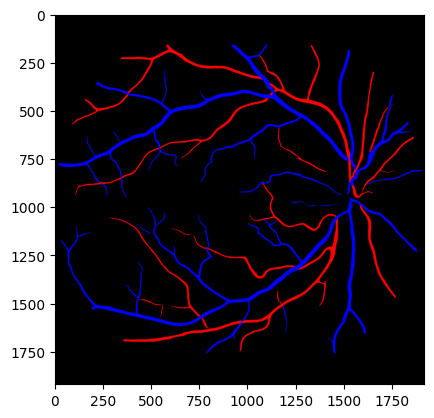

In [12]:
from pretrain.AV.config import config_test_general as cfg
    

out_test(cfg, evaluate_metrics=0)